# Process Throughput Scaling Results

## Imports, Utils, Cfg, Etc

In [33]:
import itertools
import datetime
import glob
import os
import shutil
from statistics import median
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [34]:
ROOT_DIR = Path("/lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling")
RESULTS_DIR = ROOT_DIR / "official"
PROCESSED_RESULTS_DIR = RESULTS_DIR / "my_results"
FORCE_RELOAD = False

In [35]:
sns.set_palette('colorblind')

## Agreed upon axis for study w/ Dragon

In [36]:
ax_client_nodes = [1, 32, 64, 128]
ax_clients_per_node = [1, 8, 16, 32, 64]
ax_db_nodes = [8, 16, 32]
ax_db_cpus = [36]

# dragon pool does well up to 64
ax_tensor_bytes = [8, 16, 32, 1_024, 8_192, 16_384, 32_769,65_538, 131_076, 262_152, 524_304, 1_024_000]
# ax_tensor_bytes = [1_024, 8_192, 16_384, 32_769,65_538, 131_076, 262_152, 524_304, 1_024_000]

# dragon has managers
# we do not for redis :(
# if time for key db set number of threads
# num_dragon_managers = [1, 2, 4]

ax_iterations = [100]

## Agregate Findings Across MPI Ranks

### Load in Raw Data from Study

In [37]:
def open_and_add_ctx_to_out_file(
    csv_file_path,
    client_nodes,
    clients_per_node,
    db_nodes,
    db_cpus,
    tensor_bytes,
    iterations
):
    df = pd.read_csv(csv_file_path, index_col=None, names=["Rank", "Action", "Time (Seconds)"])
    return df

def aggregate_action_data_in_df(df):
    action_groups = df[["Action", "Time (Seconds)"]].groupby("Action")
    agg_data = {}
    for action, data in action_groups:
        times = data["Time (Seconds)"]
        agg_data.update({
            f"{action}_min": times.min(),
            f"{action}_mean": times.mean(),
            f"{action}_max": times.max()
        })
    return agg_data

In [38]:
def process_throughput_out_data(results_dir, processed_dir):
    composite_data = []
    agg_data = []
    for    client_nodes,    clients_per_node,    db_nodes,    db_cpus,    tensor_bytes,    iterations in tqdm(list(itertools.product(
        ax_client_nodes, ax_clients_per_node, ax_db_nodes, ax_db_cpus, ax_tensor_bytes, ax_iterations
    )), desc="Processing scaling results...", ncols=80):
        scale_out_dir = \
            f"throughput-sess-python-N{client_nodes}-T{clients_per_node}-DBN{db_nodes}-DBCPU{db_cpus}-ITER{iterations}-TB{tensor_bytes}-*"
        dir_, *other = glob.iglob(str(results_dir / scale_out_dir))
        if other:
            print(f"WARNING: got extra, unexpected results dirs: {other};\n"
                   "         Ignoring for now!!")
        dfs = (
            open_and_add_ctx_to_out_file(
                str(csv),
                client_nodes,
                clients_per_node,
                db_nodes,
                db_cpus,
                tensor_bytes,
                iterations
            )
            for csv in glob.iglob(os.path.join(dir_, "rank_*_timing.csv"))
        )
        ranks_data_df = pd.concat(dfs, ignore_index=True)
        assert len(pd.unique(ranks_data_df["Rank"])) == client_nodes * clients_per_node

        specs = {
            "client_nodes": client_nodes,
            "clients_per_node": clients_per_node,
            "database_nodes": db_nodes,
            "database_cpus": db_cpus,
            "iterations": iterations,
            "tensor_bytes": tensor_bytes,
        }
        composite_data.append(ranks_data_df.assign(**specs))
        agg_data.append(pd.DataFrame([{
            **specs,
            **aggregate_action_data_in_df(ranks_data_df),
        }]))

    composite_df = pd.concat(composite_data, ignore_index=True)
    agg_df = pd.concat(agg_data, ignore_index=True)

    composite_df.to_csv(str(processed_dir / "composite.csv"), index=False)
    agg_df.to_csv(str(processed_dir / "processed.csv"), index=False)
    return composite_df, agg_df

def load_from_disk(res_dir):
    return (pd.read_csv(str(res_dir / "composite.csv"), index_col=None),
            pd.read_csv(str(res_dir / "processed.csv"), index_col=None))

if PROCESSED_RESULTS_DIR.is_dir() and not FORCE_RELOAD:
    print(f"Processed results dir {PROCESSED_RESULTS_DIR} detected!")
    print("Loading data from disk")
    composite_df, agg_df = load_from_disk(PROCESSED_RESULTS_DIR)
else:
    print("Processing and writing data to disk")
    shutil.rmtree(PROCESSED_RESULTS_DIR, ignore_errors=True)
    PROCESSED_RESULTS_DIR.mkdir()
    composite_df, agg_df = process_throughput_out_data(RESULTS_DIR, PROCESSED_RESULTS_DIR)

Processed results dir /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/official/my_results detected!
Loading data from disk


In [39]:
composite_df

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
0,0,client(),0.007629,1,1,8,36,100,8
1,0,put_tensor,0.000265,1,1,8,36,100,8
2,0,unpack_tensor,0.000101,1,1,8,36,100,8
3,0,put_tensor,0.000060,1,1,8,36,100,8
4,0,unpack_tensor,0.000037,1,1,8,36,100,8
...,...,...,...,...,...,...,...,...,...
198960295,4693,unpack_tensor,0.127165,128,64,32,36,100,1024000
198960296,4693,put_tensor,0.154204,128,64,32,36,100,1024000
198960297,4693,unpack_tensor,0.103299,128,64,32,36,100,1024000
198960298,4693,loop_time,34.294362,128,64,32,36,100,1024000


In [40]:
agg_df[(agg_df["client_nodes"] == 32) & (agg_df["clients_per_node"] == 32)][["database_nodes", "tensor_bytes", "put_tensor_mean", "unpack_tensor_mean"]]

,database_nodes,tensor_bytes,put_tensor_mean,unpack_tensor_mean
288,8,8,0.000742,0.000666
289,8,16,0.000741,0.000665
290,8,32,0.000757,0.000681
291,8,1024,0.000810,0.000718
292,8,8192,0.001118,0.001032
293,8,16384,0.002067,0.001271
294,8,32769,0.002983,0.002058
295,8,65538,0.005401,0.003899
296,8,131076,0.011656,0.008679
297,8,262152,0.024238,0.018853


## Plot Findings

In [41]:
nodes_and_client_per_node_to_data = {
    n_and_cpn: df for n_and_cpn, df 
    in (composite_df[composite_df["database_cpus"] == 36]
        .groupby(['client_nodes', 'clients_per_node']))
}

In [42]:
NODES = 32
CLIENTS_PER_NODE = 32

def make_throughput_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        # Fast Calc: Average over all ranks, multiply by number of ranks
        # y: group['tensor_bytes'].sum() / group['Time (Seconds)'].sum() / 1e9 * NODES * CLIENTS_PER_NODE
        # Slow Calc: Average per rank, sum up the throughput averages
        y: sum(g['tensor_bytes'].sum() / g['Time (Seconds)'].sum() for _, g in group.groupby('Rank')) / 1e9
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

plot_data = nodes_and_client_per_node_to_data[(NODES, CLIENTS_PER_NODE)]
client_num_title = f"({NODES} Nodes, {CLIENTS_PER_NODE} Clients per Node)"

### Put Tensor Times

In [43]:
put_tensor_data = plot_data[plot_data["Action"] == "put_tensor"]

In [44]:
put_tensor_data

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
6730669,655,put_tensor,0.000215,32,32,8,36,100,8
6730671,655,put_tensor,0.000116,32,32,8,36,100,8
6730673,655,put_tensor,0.000163,32,32,8,36,100,8
6730675,655,put_tensor,0.000154,32,32,8,36,100,8
6730677,655,put_tensor,0.000174,32,32,8,36,100,8
...,...,...,...,...,...,...,...,...,...
14214048,10,put_tensor,0.032881,32,32,32,36,100,1024000
14214050,10,put_tensor,0.023017,32,32,32,36,100,1024000
14214052,10,put_tensor,0.024517,32,32,32,36,100,1024000
14214054,10,put_tensor,0.017735,32,32,32,36,100,1024000


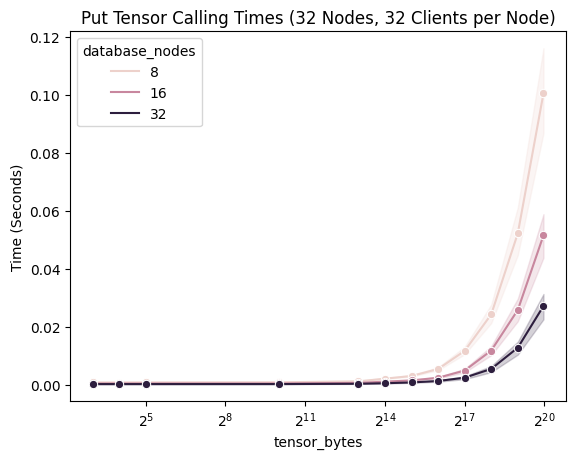

In [45]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

put_call_time_data = put_tensor_data[[x, y, hue]]
plot = sns.lineplot(put_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"Put Tensor Calling Times {client_num_title}")
plot.set_xscale('log', base=2)

### Put Tensor Throughput

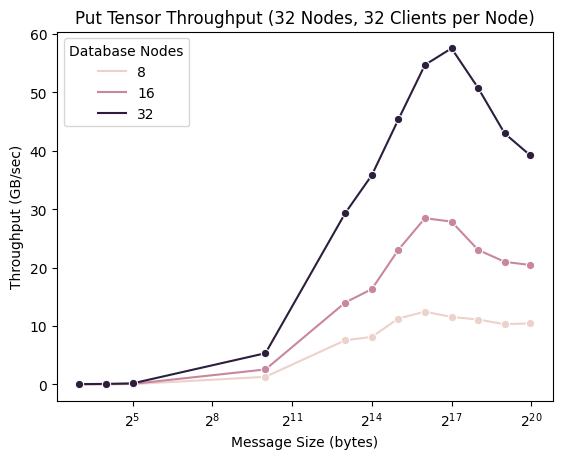

In [46]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

put_throughput_df = make_throughput_dataset(put_tensor_data, x, y, hue)
plot = sns.lineplot(put_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput {client_num_title}")
plot.set_xscale("log", base=2)

### Get Tensor Times

In [47]:
get_tensor_data = plot_data[plot_data["Action"] == "unpack_tensor"]

In [48]:
get_tensor_data

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
6730670,655,unpack_tensor,0.000162,32,32,8,36,100,8
6730672,655,unpack_tensor,0.000141,32,32,8,36,100,8
6730674,655,unpack_tensor,0.000126,32,32,8,36,100,8
6730676,655,unpack_tensor,0.000176,32,32,8,36,100,8
6730678,655,unpack_tensor,0.000176,32,32,8,36,100,8
...,...,...,...,...,...,...,...,...,...
14214049,10,unpack_tensor,0.013984,32,32,32,36,100,1024000
14214051,10,unpack_tensor,0.031986,32,32,32,36,100,1024000
14214053,10,unpack_tensor,0.020145,32,32,32,36,100,1024000
14214055,10,unpack_tensor,0.011356,32,32,32,36,100,1024000


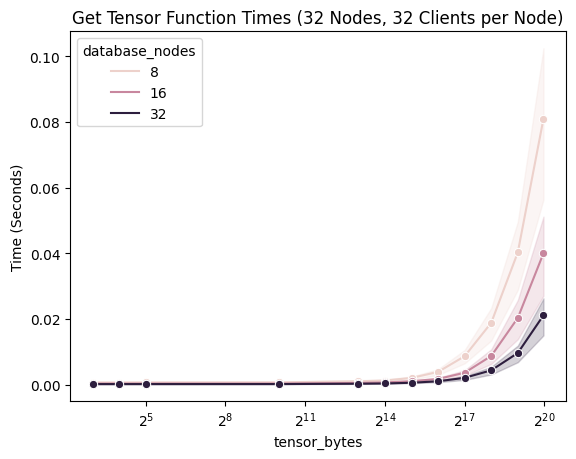

In [49]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

get_call_time_data = get_tensor_data[[x, y, hue]]
plot = sns.lineplot(get_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"Get Tensor Function Times {client_num_title}")
plot.set_xscale('log', base=2)
# plot.set_xticks(ax_tensor_bytes)
# plot.set_yscale('log', base=2)

### Get Tensor Throughput

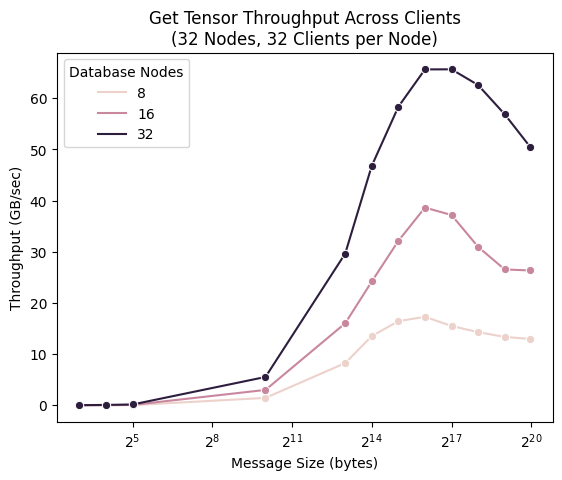

In [50]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

get_throughput_df = make_throughput_dataset(get_tensor_data, x, y, hue)
plot = sns.lineplot(get_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput Across Clients\n{client_num_title}")
plot.set_xscale('log', base=2)